# Output Preparation for the Nord_H2ub Spine Model

This jupyter notebook contains all routines for the preparation of the input data sources into a input data file for the model in Spine.

Authors: Johannes Giehl (jfg.eco@cbs.dk), Dana J. Hentschel (djh.eco@cbs.dk), Lucia Ciprian (luc.eco@cbs.dk)

## General settings

### Packages:

In [2]:
import pandas as pd
import os
import openpyxl
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def present_value_factor(n, r):
    """
    Calculate the present value factor of an annuity (Rentenbarwertfaktor).

    Parameters:
    n (int): The number of periods (time horizon).
    r (float): The discount rate (WACC).

    Returns:
    float: The present value factor of the annuity.
    """
    if r == 0:
        return n
    else:
        return (1 - (1 + r) ** -n) / r

### define parameters

In [4]:
#define if the model should use the last spine optimization results or a specific file
last_model_run = True # True or False

#set names of specific files
run_name = 'base_case'
specific_file_name = 'Output_exported' #+ run_name +'.xlsx'

#output files of this script
#file names to store the prepared output
output_prepared_export = 'output_'+ run_name +'_run.xlsx'

In [5]:
#parameters for present_value_factor calculation
time_horizon = 25  # Number of periods (years)
wacc = 0.1 * 1        # Discount rate
starting_year = "2020"

### define variables

In [6]:
#TBA

### File paths:

In [7]:
#get path of latest spine results
#parent folder
parent_folder_results = '../02_basic_energy_model/.spinetoolbox/items/exporter/output'
folders = [f for f in os.listdir(parent_folder_results) if os.path.isdir(os.path.join(parent_folder_results, f))]
if not folders:
    print("No folders found.")
else:
    latest_folder = max(folders, key=lambda x: os.path.getmtime(os.path.join(parent_folder_results, x)))
    #latest_folder = "run@2024-10-14T13.04.57"
    latest_folder_path = os.path.join(parent_folder_results, latest_folder)
latest_folder_path = latest_folder_path.replace('\\', '/')
folder_path_results = latest_folder_path
folder_path_results += '/'

#get the information of the prepared input data that is used for the spine optimization
prepared_input_file_path = os.path.join('..', '01_input_data', '02_input_prepared')

#path to files from specific runs
path_specific_runs = '02_runs_EURO/01_output_raw/'

#prepared output data export to
output_file_path = '../03_output_data/01_basic_energy_model_outputs/'

In [8]:
#set the name of the relevant files
#input files for this script

#file name export from SpineToolbox
output_exported_file = 'Output_exported.xlsx'

#input file used for the optimization
data_from_inputs = '\methanol_Input_prepared.xlsx'

#this way of the output data preparation must be changed
#the information is manually added to the input xlsx and does not exist in the automated input generation
data_from_inputs_temporary = '\methanol_Input_prepared_for_output_temporary.xlsx'

In [9]:
#combine input path and files
#to input files
file_path_data_from_inputs  = prepared_input_file_path + data_from_inputs
full_path_data_from_inputs = os.path.abspath(os.path.join(os.getcwd(), file_path_data_from_inputs))

#to specific files
full_path_specific_files = path_specific_runs + specific_file_name

#for temporary appraoch
file_path_data_from_inputs_temporary  = prepared_input_file_path + data_from_inputs_temporary
full_path_data_from_inputs_temporary = os.path.abspath(os.path.join(os.getcwd(), file_path_data_from_inputs_temporary))

## Workflow of the data preparation

### Data Import

In [10]:
if last_model_run == True:
    df_output_raw = pd.read_excel(os.path.join(folder_path_results + output_exported_file), sheet_name=-1)
else:
    df_output_raw = pd.read_excel(full_path_specific_files)

df_PV_prices = pd.read_excel(file_path_data_from_inputs, sheet_name='Energy_prices')
con_inv_params = pd.read_excel(full_path_data_from_inputs, sheet_name="Connection_Inv_Parameters")
unit_inv_params = pd.read_excel(full_path_data_from_inputs, sheet_name="Unit_Inv_Parameters")
stor_inv_params = pd.read_excel(full_path_data_from_inputs, sheet_name="Storage_Inv_Parameters")
nodes_params = pd.read_excel(full_path_data_from_inputs, sheet_name="Nodes")
model_params = pd.read_excel(full_path_data_from_inputs, sheet_name="Model")
print("Done")

Done


### data frame preparation

In [11]:
#create a copy of the original output DataFrame
df_output = df_output_raw.copy()

# Replace NaN values with empty strings in the first three rows
df_output.iloc[:3] = df_output.iloc[:3].fillna('')

# Combine the old header with the strings from the first three rows for each column
new_headers = df_output.columns + '_' + df_output.iloc[0] + '_' + df_output.iloc[1] + '_' + df_output.iloc[2]
old_headers = df_output.columns
# Set the new headers
df_output.columns = new_headers

# Drop the first three rows
#might be helpful bot not implemented now
#df_output = df_output.drop([0, 1, 2])

# Reset the index
df_output.reset_index(drop=True, inplace=True)
# Rename the first column to "timeseries"
df_output.columns.values[0] = "timeseries"

### data adjustments

In [12]:
#calculate revenues from PV sales on the wholesale market
selected_column_name = None
for column_index in range(len(df_output.columns)):
    if (df_output.iloc[0, column_index] == 'pl_wholesale' and 
        df_output.iloc[1, column_index] == 'to_node' and df_output.iloc[2, column_index] == 'power_wholesale'):         
        selected_column_name = df_output.columns[column_index]
        break

# If connected to grid PV power is sold, else revenue is 0
if 'power_wholesale_out' in df_PV_prices.columns:                 #To adjust
    if selected_column_name:
        df_output['Revenue_from_PV'] = df_output[selected_column_name].iloc[3:] * df_PV_prices['power_wholesale_out'].iloc[4]          
    else:
        print("Column with specified headers not found in output.")

else: 
    df_output['Revenue_from_PV'] = 0 

In [13]:
# Subtract slack penalty if any (Penalty costs assumed to be equal for all nodes)
slacks = df_output.filter(like='node_slack_pos')
slacks = slacks.apply(pd.to_numeric, errors='coerce')
total_slack = slacks[(slacks != 0) & (slacks.notna())].sum().sum()
# node slack penalty
slack_penalty = nodes_params['node_slack_penalty'][(nodes_params['node_slack_penalty'] != 0)&(nodes_params['node_slack_penalty'].notna())].iloc[0]

# total penalty that had to be paid 
total_slack_penalty = total_slack*slack_penalty

In [14]:
#get total cost of the system
total_costs = df_output.filter(like='total_costs')
total_costs = total_costs.apply(pd.to_numeric, errors='coerce')
total_costs = total_costs[(total_costs != 0) & (total_costs.notna())].sum().sum()
total_costs -= total_slack_penalty
#get total revenue form PV power sale (times -1 is relevant as the input is structured that negative prices for exports reduce total cost). 
total_PV_revenue = df_output['Revenue_from_PV'].sum()*(-1)
#calculate cost without PV revenue
adjusted_costs = total_costs - total_PV_revenue 
                            
#create separate DataFrame for total and adjusted cost
df_system_cost_output = pd.DataFrame({
    'Total_cost': [total_costs],
    'PV_revenue': [total_PV_revenue],
    'Total_adjusted_cost': [adjusted_costs]
})

In [15]:
# Identify columns to drop
columns_to_drop_1 = df_output.filter(like='total_costs').columns
# Drop the identified columns if any are found
if not columns_to_drop_1.empty:
    df_output.drop(columns=columns_to_drop_1, inplace=True)

#test this and implement an if check
columns_to_drop_2 = df_output.filter(like='unit_flow_op').columns
# Drop the identified columns if any are found
if not columns_to_drop_2.empty:
    df_output.drop(columns=columns_to_drop_2, inplace=True)

## calculate LCOE

calculation of levelized cost of energy

### calculate investment cost

In [16]:
dict_investments = {}
connection_costs = 0
unit_costs = 0
storage_costs = 0

## Check number of slices of roll forward
for line_number, line in model_params.iterrows():
    if line["Parameter"] == "roll_forward":
        number_str = ''.join([char for char in line["Value"] if char.isdigit()])
        number = int(number_str)
        roll_forward_slices = 8760//number
        break
    else:
        roll_forward_slices = 1


# Keep only the data of object_invested for each object 
objects_invested_df = df_output.filter(like='_invested')
objects_invested_df.iloc[4:] = objects_invested_df.iloc[4:].apply(pd.to_numeric, errors='coerce')

# Create dictionary with total number of object_invested for each object
objects_invested_dict = {}
for col_name, col_data in objects_invested_df.items():
    objects_invested_dict[col_data.iloc[0]] = col_data[3:].loc[(col_data[3:] != 0) & (col_data[3:].notna())].sum()


# Convert lifetime of '365D' for example to 365
unit_inv_params["unit_investment_econ_lifetime"] = unit_inv_params["unit_investment_econ_lifetime"].astype(str).str.replace('D', '', regex=False).astype(float)
con_inv_params["connection_investment_econ_lifetime"] = con_inv_params["connection_investment_econ_lifetime"].astype(str).str.replace('D', '', regex=False).astype(float)
stor_inv_params["storage_investment_econ_lifetime"] = stor_inv_params["storage_investment_econ_lifetime"].astype(str).str.replace('D', '', regex=False).astype(float)



# Adding investemnt costs of intially investested objects
for row_number_con, row_con in con_inv_params.iterrows():
    yearly_iv_cost = row_con["connection_investment_cost"]* roll_forward_slices   # Investment costs for full capacity and one year
    lifetime = row_con["connection_investment_econ_lifetime"]/365                 # Lifetime of object in years
    invested_available = row_con["initial_connections_invested_available"]        # Number of objects initially available for investements 
    if row_con["Object_name"] in objects_invested_dict:
        invested_opt = objects_invested_dict[row_con["Object_name"]]              # Number of objects invested in during optimization
    else: 
        invested_opt = 0
    invested_total = invested_available + invested_opt
    connection_costs += (invested_total * yearly_iv_cost * lifetime)              # Total investment costs for connections
    
for row_number_unit, row_unit in unit_inv_params.iterrows():
   
    yearly_iv_cost = row_unit["unit_investment_cost"]* roll_forward_slices
    lifetime = row_unit["unit_investment_econ_lifetime"]/365
    invested_available = row_unit["initial_units_invested_available"]
    if row_unit["Object_name"] in objects_invested_dict:
        invested_opt = objects_invested_dict[row_unit["Object_name"]]
    else: 
        invested_opt = 0
    invested_total = invested_available + invested_opt
    unit_costs += (invested_total * yearly_iv_cost * lifetime)
    
for row_number_stor, row_stor in stor_inv_params.iterrows():
    yearly_iv_cost = row_stor["storage_investment_cost"]* roll_forward_slices
    lifetime = row_stor["storage_investment_econ_lifetime"]/365
    invested_available = row_stor["initial_storages_invested"]
    if row_stor["Object_name"] in objects_invested_dict:
        invested_opt = objects_invested_dict[row_stor["Object_name"]]
    else: 
        invested_opt = 0
    invested_total = invested_available + invested_opt
    storage_costs += (invested_total * yearly_iv_cost * lifetime)
    
dict_investments["Connection_Investement_Costs"]  = connection_costs
dict_investments["Storage_Investement_Costs"]  = storage_costs
dict_investments["Unit_Investement_Costs"]  = unit_costs


total_investment = sum(dict_investments.values())
print(total_investment)

335027343.6369662


C:\Users\luc.eco\AppData\Local\Temp\ipykernel_1048\1040277338.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objects_invested_df.iloc[4:] = objects_invested_df.iloc[4:].apply(pd.to_numeric, errors='coerce')


### slacks

In [17]:
# Calculate the slacks
node_slack_neg = df_output.filter(like='node_slack_neg')
node_slack_pos = df_output.filter(like='node_slack_pos')

node_slack_neg_numeric = node_slack_neg.apply(pd.to_numeric, errors='coerce')
node_slack_pos_numeric = node_slack_pos.apply(pd.to_numeric, errors='coerce')

node_slack_neg_sum = node_slack_neg_numeric.sum().sum()
node_slack_pos_sum = node_slack_pos_numeric.sum().sum()

total_slack = node_slack_neg_sum + node_slack_pos_sum

### variable costs

In [18]:
#get annual costs
#annual_costs = df_system_cost_output.loc['total_costs_toy__', 'Total_adjusted_cost'] - total_slack
annual_costs = adjusted_costs-total_slack
#annual cost including PV revenue
#annual_costs_with_PV = df_system_cost_output.loc['total_costs_toy__', 'Total_cost'] - total_slack
annual_costs_with_PV = total_costs-total_slack

### energy output

In [19]:
#energy output
energy_output = df_output.filter(like='dist_tower_to_node_ch3oh')         

# Convert strings to numbers, ignoring non-numeric values (relevant as first rows are strings)
energy_output_value = pd.to_numeric(energy_output.iloc[:,0], errors='coerce').sum() * 24

In [20]:
#calculation of the present value factor
pcf_value = present_value_factor(time_horizon, wacc)

LCOE = (total_investment + (annual_costs * pcf_value)) / (energy_output_value * pcf_value)
LCOE_PV = (total_investment + (annual_costs_with_PV * pcf_value)) / (energy_output_value * pcf_value)

In [21]:
#create a pandas data frame with all LCOE information

LCOE_GJ = LCOE/3.6
LCOE_t = LCOE_GJ*19.9

LCOE_GJ_PV = LCOE_PV/3.6
LCOE_PV_t = LCOE_GJ_PV*19.9

energy_output_value_t = (energy_output_value * 3.6) / 19.9


# Create a dictionary with the parameters
data_LCOE = {
    'LCOE [Euro/MWh]': LCOE,
    'LCOE [Euro/t]': LCOE_t,
    'total_investment': total_investment,
    'annual_costs': annual_costs,
    'energy_production [MWh]': energy_output_value,
    'energy_production [t]': energy_output_value_t,
    'pcf_value': pcf_value,
    'run_name': run_name
}

data_LCOE_PV = {
    'LCOE [Euro/MWh]': LCOE_PV,
    'LCOE [Euro/t]': LCOE_PV_t,
    'total_investment': total_investment,
    'annual_costs': annual_costs_with_PV,
    'energy_production [MWh]': energy_output_value,
    'energy_production [t]': energy_output_value_t,
    'pcf_value': pcf_value,
    'run_name': run_name + '_PV'
}

# Convert the dictionary to a DataFrame and set the index to the run name
df_LCOE_information = pd.DataFrame([data_LCOE])
df_LCOE_information.set_index('run_name', inplace=True)

df_LCOE_PV_information = pd.DataFrame([data_LCOE_PV])
df_LCOE_PV_information.set_index('run_name', inplace=True)

df_LCOE = pd.concat([df_LCOE_information, df_LCOE_PV_information])

### Creating one combined excel and export

In [22]:
'''with pd.ExcelWriter(output_file_path + output_prepared_export) as writer:
    df_output.to_excel(writer, sheet_name='flows_node_states')
    df_system_cost_output.to_excel(writer, sheet_name='system_costs')
    df_LCOE.to_excel(writer, sheet_name='LCOE')'''

"with pd.ExcelWriter(output_file_path + output_prepared_export) as writer:\n    df_output.to_excel(writer, sheet_name='flows_node_states')\n    df_system_cost_output.to_excel(writer, sheet_name='system_costs')\n    df_LCOE.to_excel(writer, sheet_name='LCOE')"

In [23]:
df_LCOE

LCOE [Euro/MWh]  LCOE [Euro/t]  total_investment  annual_costs  \
run_name                                                                       
base_case         7719.282552   42670.478550      3.350273e+08  3.258161e+10   
base_case_PV      7721.037963   42680.182076      3.350273e+08  3.258902e+10   

              energy_production [MWh]  energy_production [t]  pcf_value  
run_name                                                                 
base_case                4.225589e+06          764428.149804    9.07704  
base_case_PV             4.225589e+06          764428.149804    9.07704

### Calculation of Carbon contract for Difference (CCfD)-price

In [45]:
avg_EUA_2019 = 24.723125       #€/(t*CO2-eq)  (https://icapcarbonaction.com/en/ets-prices)
avg_EUA_2020 = 24.38660287     #€/(t*CO2-eq)
avg_EUA_2021 = 54.15156951     #€/(t*CO2-eq)
avg_EUA_2022 = 80.18404545     #€/(t*CO2-eq)
avg_EUA_2023 = 83.59650224     #€/(t*CO2-eq)

EUA_2024_2050_DKK = np.array([537, 559, 583, 607, 633, 661, 690, 722, 756, 792, 831, 871, 914, 960, 1008, 1059, 1113, 1171, 1232, 1297, 1366, 1440, 1518, 1601, 1689, 1783, 1884])
# https://fm.dk/media/4tkj2o4w/noegletalskatalog_juni-2024.pdf
exchange_rate = 0.1338
EUA_2024_2050_EUR = EUA_2024_2050_DKK * exchange_rate
EUA_2023_2050_EUR = np.insert(EUA_2024_2050_EUR,0, avg_EUA_2023)
EUA_2019_2024_EUR = np.array([avg_EUA_2019, avg_EUA_2020, avg_EUA_2021, avg_EUA_2022, avg_EUA_2023])
EUA_all = np.concatenate((np.array([avg_EUA_2019, avg_EUA_2020, avg_EUA_2021, avg_EUA_2022, avg_EUA_2023]), EUA_2024_2050_EUR), axis=None)


In [46]:
# methanol data for calculations
demand_daily_Wh = 20.1928*10**6                          # Wh
price_methanol = 277.8
#price_methanol = 360                                     # €/tonne        (https://www.methanex.com/sites/default/files/methanol-price/Mx-Price-Sheet%20-%20Jan%2029%2C%202019.pdf)
energy_density = 19.7*10**9                              # J/tonne      
co2_equiv = 105*10**(-12)                                # t*CO2-eq/J
emissions_of_hub = 0

# Daily demand
demand_daily_J = demand_daily_Wh*3600
demand_daily_t = demand_daily_J/energy_density

# CO2-eq. per daily methanol and per tonne methanol
co2_per_day = co2_equiv * demand_daily_J
co2_per_tonne = co2_per_day / demand_daily_t

# Methanol price excluding CO2 price to have the production costs
costs_methanol = price_methanol - avg_EUA_2019* co2_per_tonne    # €/tonne
daily_costs_conventional_M = costs_methanol * demand_daily_t           # €

# Costs for modelled methanol per day without PV revnue
#daily_costs_renewable_M_2019 = LCOE_t * demand_daily_t                       #€
daily_costs_renewable_M_2019 = 1415.7 * demand_daily_t                        #€
daily_costs_renewable_M_2050 = 962.54 * demand_daily_t                        #€

# Costs for modelled methanol per day with PV revnue
daily_costs_renewable_M_2019_PV = 1121.11 * demand_daily_t                        #€
daily_costs_renewable_M_2050_PV = 755.99 * demand_daily_t                        #€


# Cost and Emission differences 
Delta_costs_2019 = daily_costs_renewable_M_2019 - daily_costs_conventional_M
Delta_costs_2050 = daily_costs_renewable_M_2050 - daily_costs_conventional_M
Delta_emissions = co2_per_day- emissions_of_hub

# Cost and Emission differences with PV revnue
Delta_costs_2019 = daily_costs_renewable_M_2019_PV - daily_costs_conventional_M
Delta_costs_2050 = daily_costs_renewable_M_2050_PV - daily_costs_conventional_M
Delta_emissions = co2_per_day- emissions_of_hub

# CCfD price
CCfD_2019 = Delta_costs_2019/Delta_emissions
CCfD_2050 = Delta_costs_2050/Delta_emissions

# Necessary CO_2 price for 2050 if no CCfD
LCOE_t_2050 = 962.54
price_per_co2_2050 = -(costs_methanol-LCOE_t_2050)/co2_per_tonne 

print(CCfD_2019, CCfD_2050, price_per_co2_2050)

529.963613155061 313.0887627123714 313.08876271237136


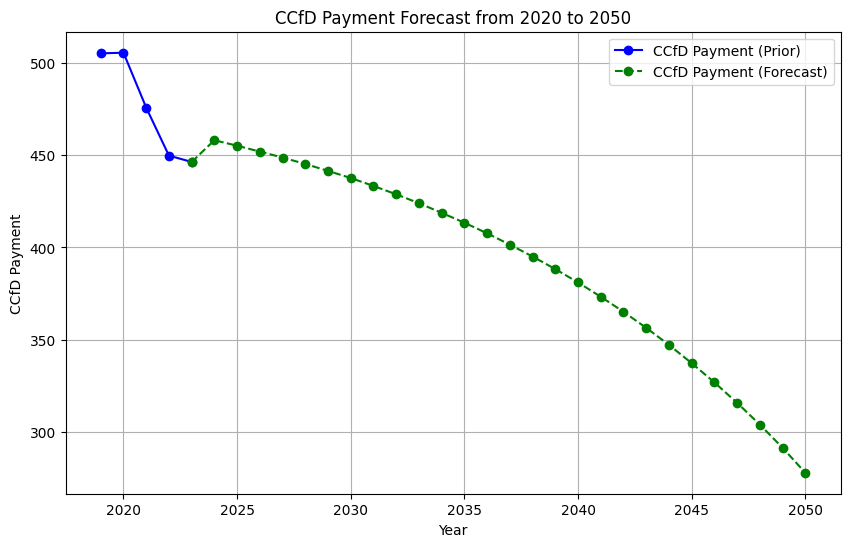

In [47]:
#Plotting CCfD for years 2020-2050
#co2_prices_forecast = np.arange(25, 285, (260/30))
#linear_CCfD = np.arange(CCfD_2019, CCfD_2050, ((CCfD_2050-CCfD_2019)/30))

CCfD_array_long= np.full(len(EUA_2023_2050_EUR), CCfD_2019)
CCfD_array_short = np.full(len(EUA_2019_2024_EUR), CCfD_2019)

CCfD_payment_forecast = CCfD_array_long - EUA_2023_2050_EUR
CCfD_payment_prior = CCfD_array_short - EUA_2019_2024_EUR

years_prior = np.arange(2019, 2024) 
years_forecast = np.arange(2023, 2051)  # 2023 to 2050


# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(years_forecast, CCfD_payment_forecast, marker='o', linestyle='--', color='g', label="CCfD Payment (Forecast)")
plt.plot(years_prior, CCfD_payment_prior, marker='o', color='b', label="CCfD Payment (Prior)")

plt.xticks(np.arange(2020, 2051, 5))

plt.xlabel("Year")
plt.ylabel("CCfD Payment [€/t]")
plt.title("CCfD Payment Forecast from 2020 to 2050")
plt.legend()
plt.grid(True)
plt.show()

